In [1]:
### Import the dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
### Data Loading and understanding
df = pd.read_csv('../data/movies.csv')

In [3]:
df.shape

(4803, 24)

In [4]:
df.head(2)

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 4803 non-null   int64  
 1   budget                4803 non-null   int64  
 2   genres                4775 non-null   object 
 3   homepage              1712 non-null   object 
 4   id                    4803 non-null   int64  
 5   keywords              4391 non-null   object 
 6   original_language     4803 non-null   object 
 7   original_title        4803 non-null   object 
 8   overview              4800 non-null   object 
 9   popularity            4803 non-null   float64
 10  production_companies  4803 non-null   object 
 11  production_countries  4803 non-null   object 
 12  release_date          4802 non-null   object 
 13  revenue               4803 non-null   int64  
 14  runtime               4801 non-null   float64
 15  spoken_languages     

In [6]:
### filter the required column for recommandation
required_column = ["genres", "keywords", "overview", "title"]

df = df[required_column]

In [7]:
df.shape

(4803, 4)

In [8]:
df.head(2)

,genres,keywords,overview,title
0,Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,"In the 22nd century, a paraplegic Marine is di...",Avatar
1,Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,"Captain Barbossa, long believed to be dead, ha...",Pirates of the Caribbean: At World's End


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   genres    4775 non-null   object
 1   keywords  4391 non-null   object
 2   overview  4800 non-null   object
 3   title     4803 non-null   object
dtypes: object(4)
memory usage: 150.2+ KB


In [10]:
df = df.dropna().reset_index(drop=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4387 entries, 0 to 4386
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   genres    4387 non-null   object
 1   keywords  4387 non-null   object
 2   overview  4387 non-null   object
 3   title     4387 non-null   object
dtypes: object(4)
memory usage: 137.2+ KB


In [12]:
df['combined'] = df['genres'] + ' ' + df['keywords'] + ' ' + df['overview']

In [13]:
df.head(2)

,genres,keywords,overview,title,combined
0,Action Adventure Fantasy Science Fiction,culture clash future space war space colony so...,"In the 22nd century, a paraplegic Marine is di...",Avatar,Action Adventure Fantasy Science Fiction cultu...
1,Adventure Fantasy Action,ocean drug abuse exotic island east india trad...,"Captain Barbossa, long believed to be dead, ha...",Pirates of the Caribbean: At World's End,Adventure Fantasy Action ocean drug abuse exot...


In [14]:
df.tail()

,genres,keywords,overview,title,combined
4382,Drama,gang audition police fake homeless actress,A young woman in L.A. is having a bad day: she...,Bang,Drama gang audition police fake homeless actre...
4383,Science Fiction Drama Thriller,distrust garage identity crisis time travel ti...,Friends/fledgling entrepreneurs invent a devic...,Primer,Science Fiction Drama Thriller distrust garage...
4384,Action Crime Thriller,united states\u2013mexico barrier legs arms pa...,El Mariachi just wants to play his guitar and ...,El Mariachi,Action Crime Thriller united states\u2013mexic...
4385,Comedy Drama Romance TV Movie,date love at first sight narration investigati...,"""Signed, Sealed, Delivered"" introduces a dedic...","Signed, Sealed, Delivered",Comedy Drama Romance TV Movie date love at fir...
4386,Documentary,obsession camcorder crush dream girl,Ever since the second grade when he first saw ...,My Date with Drew,Documentary obsession camcorder crush dream gi...


In [15]:
data = df[['title', 'combined']]

In [16]:
data.head(2)

,title,combined
0,Avatar,Action Adventure Fantasy Science Fiction cultu...
1,Pirates of the Caribbean: At World's End,Adventure Fantasy Action ocean drug abuse exot...


In [17]:
data.shape

(4387, 2)

In [18]:
### Word Cloud for movie content
combined_text = ' '.join(data['combined'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_text)

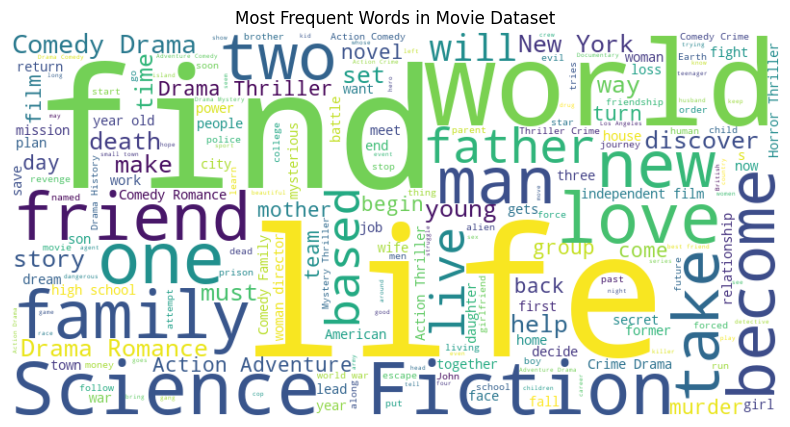

In [19]:
### Wordcloud to visualize the most frequent words in the dataset
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Words in Movie Dataset")
plt.show()

In [20]:
### filtering the stopwords

def preprocess_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove special characters and numbers
    text = text.lower()  
    tokens = word_tokenize(text) 
    tokens = [word for word in tokens if word not in stopwords.words("english")]  

    return " ".join(tokens)
 

In [ ]:
### Apply preprocessing to the movie content
data['combined_text'] = data['combined'].apply(preprocess_text)

In [ ]:
data.head()

,title,combined,combined_text
0,Avatar,Action Adventure Fantasy Science Fiction cultu...,action adventure fantasy science fiction cultu...
1,Pirates of the Caribbean: At World's End,Adventure Fantasy Action ocean drug abuse exot...,adventure fantasy action ocean drug abuse exot...
2,Spectre,Action Adventure Crime spy based on novel secr...,action adventure crime spy based novel secret ...
3,The Dark Knight Rises,Action Crime Drama Thriller dc comics crime fi...,action crime drama thriller dc comics crime fi...
4,John Carter,Action Adventure Science Fiction based on nove...,action adventure science fiction based novel m...


In [ ]:
### Vectorization with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(data['combined_text'])

In [ ]:
### Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [ ]:
### Recommandation Function
def recommend_movies(movie_name, cosine_sim=cosine_sim, df=data, top_n=5):
    # Find the index of the movie that matches the title
    idx = df[df['title'].str.lower() == movie_name.lower()].index
    idx = idx[0] 

    ### Get Similar scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]  # Exclude the first one (itself)

    ### Get movie indices
    movie_indices = [i[0] for i in sim_scores]

    ### Return the top n most similar movies
    return df['title'].iloc[movie_indices]

In [ ]:
data['title']

0                                         Avatar
1       Pirates of the Caribbean: At World's End
2                                        Spectre
3                          The Dark Knight Rises
4                                    John Carter
                          ...                   
4382                                        Bang
4383                                      Primer
4384                                 El Mariachi
4385                   Signed, Sealed, Delivered
4386                           My Date with Drew
Name: title, Length: 4387, dtype: object

In [ ]:
row_index = df[df['title'] == "Avengers: Age of Ultron"].index
row_index

Index([7], dtype='int64')

In [ ]:
movie_name = data['title'][7]
movie_name

'Avengers: Age of Ultron'

In [ ]:
### Example of movie recommendation
print(f"Recommendations for the movie '{movie_name}':")
recommended_movies = recommend_movies(movie_name)   
print(recommended_movies)

Recommendations for the movie 'Avengers: Age of Ultron':
78                     Iron Man 2
68                       Iron Man
16                   The Avengers
46     X-Men: Days of Future Past
506                         X-Men
Name: title, dtype: object
